Download and extract data.


In [1]:
# remove all files present
!rm -rfv ./*
#download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri" -O Data.zip && rm -rf /tmp/cookies.txt
# unzip
!unzip -q Data.zip
# remove zip 
!rm -rf ./Data.zip


removed './sample_data/README.md'
removed './sample_data/anscombe.json'
removed './sample_data/mnist_test.csv'
removed './sample_data/california_housing_test.csv'
removed './sample_data/mnist_train_small.csv'
removed './sample_data/california_housing_train.csv'
removed directory './sample_data'
--2020-08-08 16:56:12--  https://docs.google.com/uc?export=download&confirm=I6GE&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri
Resolving docs.google.com (docs.google.com)... 74.125.28.102, 74.125.28.139, 74.125.28.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.28.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-08-docs.googleusercontent.com/docs/securesc/rb80sn85uchl55494vbgsaafamikl1tf/bhu1s8cj3hon6e3m8ijvhmk7pib642pe/1596905700000/07496480791912752493/01454856039667526000Z/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri?e=download [following]
--2020-08-08 16:56:12--  https://doc-10-08-docs.googleusercontent.com/docs/securesc/rb80sn85uchl55

In [2]:
# code block 1
# import
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.random.set_seed(12345)
import glob

2.3.0


In [3]:
# code block 2
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE
Batch_Size = 32 #batch size used in the code.
KNeghb = 6 #Number to top N images needed.
PATHS = glob.glob('./dataset/*.jpg')
IMG_SHAPE = (224,224,3)
print(PATHS[:5])

def decode_image(filename, label=None, image_size=IMG_SHAPE[:-1]):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    return image
def create_dataset(path, image_size = None):
  dataset = (
      tf.data.Dataset
      .from_tensor_slices(PATHS)
      .map(decode_image, num_parallel_calls=AUTO)
      .batch(Batch_Size)
  )
  return dataset

['./dataset/1130.jpg', './dataset/2821.jpg', './dataset/4550.jpg', './dataset/1188.jpg', './dataset/4733.jpg']


In [4]:
dataset = create_dataset(PATHS)

Till now we have downloaded created the datapipeline now we should proceed with the problem that is finding similar N images.


# Creating AutoEncoder to train our own CNN.

The main theme is to extract feature from the images and then use them to find the similar images.

In version 1 we have used the pretrained model to get the results in this part we will try to create our own model from scratch and train it.

For this task we will use CNN autoencoder to as it is a image dataset and CNN can learn it much efficently than normal FeedForward network.

In [5]:
import os

class AutoEncoder():
  def __init__(self,imageSize):
    self.IMG_SIZE = imageSize
    self.encoder = None
    self.autoencoder = None

  def make(self):
    # we have 3 hidden layers
    lay_1,lay_2,lay_3, lay_4 = 64,32,16,8
    #conv. kernel size, we are not taking bigger kernel as we dont want to loose info.
    Ker_size = (3,3)
    ker_size2 = (5,5)
    #Max-pool kernal size
    pool_size = (2,2)

    input = tf.keras.layers.Input(shape=self.IMG_SIZE)
    x = tf.keras.layers.Conv2D(lay_1, Ker_size, activation='relu', padding='same')(input)
    #x = tf.keras.layers.MaxPooling2D(pool_size, padding='same')(x)
    x = tf.keras.layers.Conv2D(lay_2, Ker_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(lay_3, Ker_size, activation='relu', padding='same')(x)
    #x = tf.keras.layers.MaxPooling2D(pool_size, padding='same')(x)
    x = tf.keras.layers.Conv2D(lay_4, Ker_size, activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D(pool_size, padding='same')(x)

    x = tf.keras.layers.Conv2D(lay_4, Ker_size, activation='relu', padding='same')(encoded)
    #x = tf.keras.layers.UpSampling2D(pool_size)(x)
    x = tf.keras.layers.Conv2D(lay_3, Ker_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(lay_2, Ker_size, activation='relu', padding='same')(x)
    #x = tf.keras.layers.UpSampling2D(pool_size)(x)
    x = tf.keras.layers.Conv2D(lay_1, Ker_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D(pool_size)(x)
    decoded = tf.keras.layers.Conv2D(self.IMG_SIZE[2], Ker_size, activation='sigmoid', padding='same')(x)

    # creating model
    autoencoder = tf.keras.Model(input,decoded)
    print(f"Autoencoder input shape is {autoencoder.layers[0].input_shape[1:]}")
    print(f"Autoencoder output shape is {autoencoder.layers[-1].output_shape[1:]}")

    # create encoder model
    encoder = tf.keras.Model(input, encoded)
    print(f"Encoder input shape is {encoder.layers[0].input_shape[1:]}")
    print(f"Encoder output shape is {encoder.layers[-1].output_shape[1:]}")

    # Summary
    print("\n Autoencoder summary:- ")
    print(autoencoder.summary())
    print("\n Encoder summary :- ")
    print(encoder.summary())
    
    self.encoder = encoder
    self.autoencoder = autoencoder

  # Compile
  def compile(self, loss="binary_crossentropy", optimizer="adam"):
    self.autoencoder.compile(optimizer=optimizer, loss=loss)

  # train model:-
  class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('val_loss')<0.4):
        print("\nReached 60% accuracy so cancelling training!")
        self.model.stop_training = True
  def fit(self, dataset, batch_size=256):
    callbacks = self.myCallback()
    val = int(4738*0.9)
    auto_data = tf.data.Dataset.zip((dataset, dataset))
    data_train = auto_data.take(val) 
    data_valid = auto_data.skip(val)
    self.autoencoder.fit(data_train,
                          epochs = 50,
                         #callbacks = [callbacks],
                          batch_size = batch_size,
                         validation_steps = 1,
                          validation_data = data_valid)


  # Save model architecture and weights to file
  def save_models(self,folderpath):
    os.mkdir(folderpath)
    print("Saving models...")
    self.autoencoder.save(folderpath+"/autoencoder.h5")
    self.encoder.save(folderpath+"/encoder.h5")

  # Load model architecture and weights
  def load_models(self, folderpath, loss="binary_crossentropy", optimizer="adam"):
    print("Loading models...")
    if os.path.exists(folderpath+"/autoencoder.h5"):
      self.autoencoder = tf.keras.models.load_model(folderpath+"/autoencoder.h5")
      self.encoder = tf.keras.models.load_model(folderpath+"/encoder.h5")
      self.autoencoder.compile(optimizer=optimizer, loss=loss)
      self.encoder.compile(optimizer=optimizer, loss=loss)
    else:
      raise Exception("Invalid path given!")


  # get feature
  def get_feature(self, X):
    return self.encoder.predict(X)







In [ ]:
len(PATHS)

4738

In [8]:
# using autoencoder 
model = AutoEncoder(IMG_SHAPE)
model.make()
path = "./out"
if not os.path.exists(path):
  # model.compile(loss="binary_crossentropy", optimizer="adam")
  # model.fit(dataset, batch_size=Batch_Size)
  # model.save_models(path)
  pass

else:
  model.load_models(path,loss="binary_crossentropy", optimizer="adam")

Autoencoder input shape is []
Autoencoder output shape is (224, 224, 3)
Encoder input shape is []
Encoder output shape is (112, 112, 8)

 Autoencoder summary:- 
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 32)      18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 16)      4624      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooli

In [ ]:
model.save_models(path)

Saving models...


lets see how the autoencoder is performing


input:- 


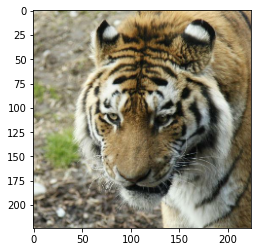

output:- 


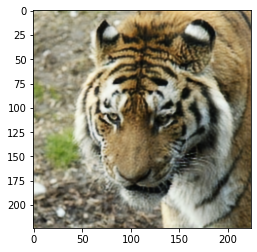

In [9]:
import matplotlib.pyplot as plt
image = decode_image('./dataset/0.jpg')
print("input:- ")
plt.imshow(image)
plt.show()
print("output:- ")
image = tf.expand_dims(image,axis=0)
plt.imshow(tf.squeeze(model.autoencoder.predict(image)))
plt.show()

In [10]:
# run it only once
import h5py
import numpy as np
import os

def save_prediction_simple(dataset,model):
  path = './out.h5'
  out_shape = model.encoder.layers[-1].output_shape[1:]
  if not os.path.exists(path):
    with h5py.File(path, "w") as f:
      pred = model.get_feature(dataset)
      pred = pred.reshape((-1, np.prod(out_shape)))
      f.create_dataset("Feature_map",  data=pred)

save_prediction_simple(dataset,model)

Now we have extracted the feature of all the images in the data set. lets now compare them with the query image. This to obtain the cosine similarity.

In [11]:
import h5py
from sklearn.neighbors import NearestNeighbors

def get_KNN(file_input, KNeghb):
  knn = NearestNeighbors(n_neighbors=KNeghb, metric="euclidean")
  with h5py.File(file_input, "r") as f:
    features = f['Feature_map']
    print(features.shape)
    print("Fitting k-nearest-neighbour model on training images...")
    knn.fit(features)
    f.close()
  return knn


knn = get_KNN('out.h5',KNeghb)


(4738, 100352)
Fitting k-nearest-neighbour model on training images...


In [12]:
import numpy as np
import matplotlib.pyplot as plt
def plot_query_retrieval(img_query, imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(2*n_retrieval, 4))
    fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

    # Plot query image
    ax = plt.subplot(2, n_retrieval, 0 + 1)
    plt.imshow(decode_image(img_query))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(4)  # increase border thickness
        ax.spines[axis].set_color('black')  # set to black
    ax.set_title("query",  fontsize=14)  # set subplot title

    # Plot retrieval images
    for i, img in enumerate(imgs_retrieval):
        ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
        plt.imshow(decode_image(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1)  # set border thickness
            ax.spines[axis].set_color('black')  # set to black
        ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()

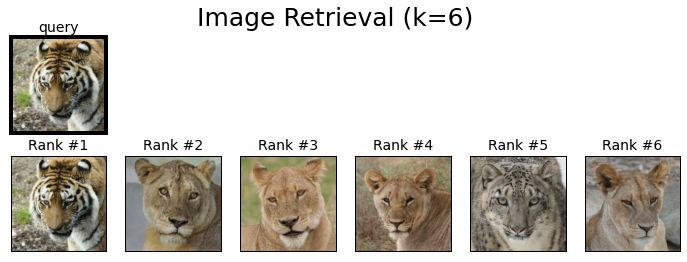

In [13]:
def get_n_images(query,knn,model):
  out_shape = model.encoder.layers[-1].output_shape[1:]
  image = decode_image(query)
  image = tf.expand_dims(image,axis=0)
  query_feature = model.get_feature(image)
  flat_query_feature = query_feature.reshape((-1,np.prod(out_shape)))
  _, indices = knn.kneighbors(flat_query_feature)
  imgs_retrieval = [PATHS[idx] for idx in indices.flatten()]
  plot_query_retrieval(query, imgs_retrieval, None)

get_n_images('./dataset/0.jpg',knn,model)

Now lets check the code.


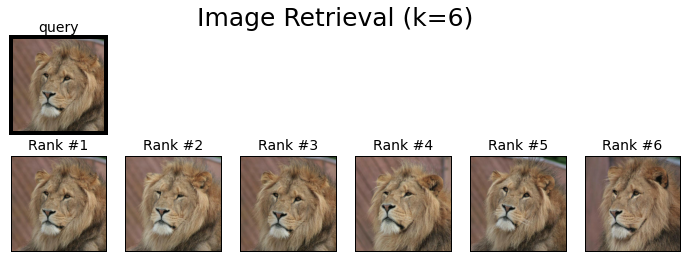

In [14]:
get_n_images('./dataset/3.jpg',knn,model)

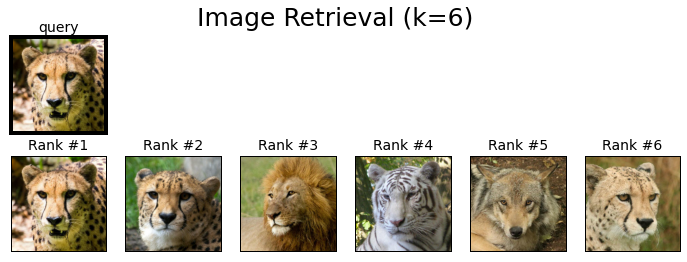

In [15]:
get_n_images('./dataset/9.jpg', knn, model)

lets try feature wise selection, zebra is black and white striped, thus we aim to see some thing striped in our results.

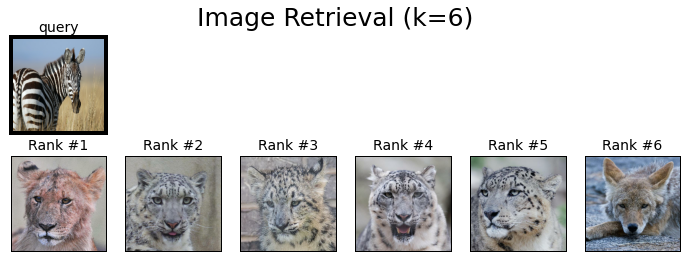

In [16]:
get_n_images('zebra.jpg', knn, model)

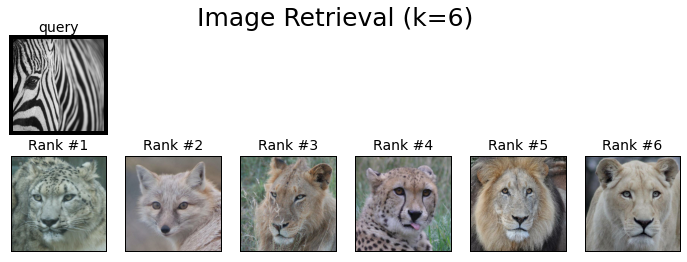

In [17]:
get_n_images('zebra2.jpg', knn, model)

the performance is not as good as we aspected, the problem is that we are not able to learn from images as multiple maxpool are there at eaxh step the information is lost. lets, first try with full image shape, as we have reduced the image size to 224x224 let make it 512x512 so that the same model has more information to extract.
lets re run the code with new pammeter.